# Getting the information


In [ ]:
#@title Libraries
import requests
from google.colab import drive
import pandas as pd
import os
from bs4 import BeautifulSoup
import json
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#@title Connecting to Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Reading the csv file

%cd /content/drive/MyDrive/Colab Notebooks/WebAnalytics/final

songs_info = pd.read_csv('song_feat_moods.csv')

df = pd.read_csv('song_feat_moods.csv')
df = df.iloc[:, 1:]
df

/content/drive/MyDrive/Colab Notebooks/WebAnalytics/final


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,mood,popularity,release_date
0,0.439,0.482,0,-8.226,1,0.0946,0.58300,0.000000,0.1420,0.368,179.884,5vK8ILrHjXjdZJHp0AtEVJ,185554,4,chill,48,2022-03-04
1,0.766,0.333,7,-13.775,0,0.0558,0.82400,0.001700,0.1590,0.450,95.951,0mzvDQW1IgLuXAwD5YMN6i,126985,4,chill,49,2021-03-12
2,0.757,0.631,0,-6.886,1,0.0302,0.00703,0.008650,0.0931,0.264,125.983,1L4f4kyGeaLdZeVhPLaD8j,185813,4,chill,47,2021-12-09
3,0.734,0.425,9,-8.585,1,0.1170,0.79000,0.000013,0.1070,0.361,80.898,4IKSehYf4e9tjijDSZHQF2,133333,4,chill,51,2022-02-04
4,0.627,0.426,6,-5.994,1,0.0291,0.88300,0.001780,0.1100,0.498,67.520,7tAsrC5tNcbccUmMnRsmZI,189732,4,chill,46,2021-12-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476,0.854,0.766,9,-4.697,0,0.1410,0.02420,0.000000,0.0793,0.784,118.004,2S5LNtRVRPbXk01yRQ14sZ,224258,4,disconnecting,66,2015-04-07
4477,0.693,0.822,4,-5.441,0,0.0439,0.00616,0.000002,0.3150,0.763,126.035,3zrYNl1aMdFrQkcOjKVr5u,223800,4,disconnecting,59,2012-06-22
4478,0.747,0.739,11,-3.318,0,0.0733,0.04750,0.000000,0.2130,0.663,127.959,3bhvFZ2eJMuWakoDYZdaR5,205040,4,disconnecting,49,2011-08-30
4479,0.804,0.836,6,-6.635,0,0.0890,0.32000,0.000000,0.2130,0.850,120.046,7mS8RbJji2UZAaguRGsOCH,223773,4,disconnecting,60,2003-11-13


In [ ]:
df = df.set_index('id')
df = df.drop_duplicates(subset=df.columns.difference(['mood']))
labels = df['mood']
df = df.drop('mood', axis=1)

In [ ]:
#we will not take into account:
  #realease date
df = df.drop('release_date', axis=1)

# Functions


In [ ]:
#@title cosine similatiry

def cosine_similarity2(A, B):
  cosine = np.dot(A,B)/(norm(A)*norm(B))
  return cosine

In [ ]:
#@title Correlation matrix

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)  #loudness and energy


<ipython-input-9-3037933890fb>:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)  #loudness and energy


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
danceability,1.00,0.32,0.05,0.37,-0.13,0.20,-0.32,-0.28,-0.02,0.51,-0.08,-0.30,0.25,0.15
energy,0.32,1.00,0.05,0.74,-0.12,0.08,-0.75,-0.19,0.22,0.45,0.19,-0.16,0.20,0.21
key,0.05,0.05,1.00,0.03,-0.11,0.03,-0.04,-0.02,-0.00,0.06,0.04,-0.02,0.01,0.01
loudness,0.37,0.74,0.03,1.00,-0.07,0.04,-0.58,-0.47,0.16,0.38,0.17,-0.22,0.22,0.27
mode,-0.13,-0.12,-0.11,-0.07,1.00,-0.07,0.13,-0.01,-0.03,-0.05,0.00,0.05,-0.03,-0.03
speechiness,0.20,0.08,0.03,0.04,-0.07,1.00,-0.07,-0.09,0.07,0.14,0.07,-0.12,0.06,-0.00
acousticness,-0.32,-0.75,-0.04,-0.58,0.13,-0.07,1.00,0.16,-0.15,-0.35,-0.15,0.08,-0.18,-0.14
instrumentalness,-0.28,-0.19,-0.02,-0.47,-0.01,-0.09,0.16,1.00,-0.05,-0.31,-0.06,0.26,-0.14,-0.24
liveness,-0.02,0.22,-0.00,0.16,-0.03,0.07,-0.15,-0.05,1.00,0.10,0.03,-0.06,0.03,0.04
valence,0.51,0.45,0.06,0.38,-0.05,0.14,-0.35,-0.31,0.10,1.00,0.05,-0.19,0.18,0.17


In [ ]:
matrix_df = df.values

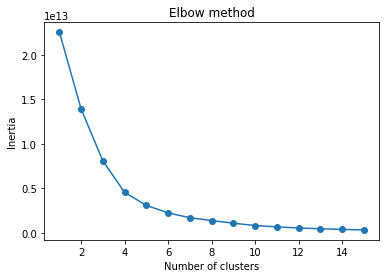

In [ ]:
inertias = []

tot_k = 16
for i in range(1,tot_k):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(matrix_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,tot_k), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

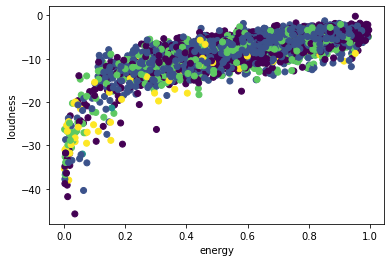

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(matrix_df)

plt.scatter(matrix_df[:,1], matrix_df[:,3], c=kmeans.labels_) #0:danceability, 1:energy, 2:key, 3:loudness
plt.xlabel('energy')
plt.ylabel('loudness')
plt.show() 

#we cannot see it in the plot (not representative) even using loudness and energy (that are the ones that seemas more correlated)
#the correlation between them is exponential

# Supervised Clustering - KNN

In [ ]:
n = 10
np.random.seed(n)

## USING SCALER
#first save song to test
test_song = df.loc[random.sample(df.index.to_list(), 1)[0],:]
label_song = labels[test_song.name]
df = df.drop(test_song.name, axis =0)
labels = labels.drop(test_song.name, axis =0)
print("test song:\n", test_song)
matrix_df = df.values

scaler = StandardScaler()
df_scaled = scaler.fit_transform(matrix_df)

test song:
 danceability             0.710000
energy                   0.799000
key                      6.000000
loudness                -4.897000
mode                     1.000000
speechiness              0.032800
acousticness             0.220000
instrumentalness         0.000602
liveness                 0.349000
valence                  0.725000
tempo                  120.372000
duration_ms         238267.000000
time_signature           4.000000
popularity              78.000000
Name: 4y1LsJpmMti1PfRQV9AWWe, dtype: float64


In [ ]:
##USING PCA
np.random.seed(n)

pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(df_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}\n'.format(np.sum(pca_2.explained_variance_ratio_)))

# Split dataset into training set and test set
train, test, ids_train, ids_test = train_test_split(pca_2_result, labels, test_size=0.2) # 80% training and 20% test

#___________________________________________________
for k in range(len(labels.unique())-2, len(labels.unique())+3):
  knn = KNeighborsClassifier(n_neighbors=k)

  #Train the model using the training sets
  knn.fit(train, ids_train.values)

  #Predict the response for test dataset
  y_pred = knn.predict(test)
  print("K-", k, " Accuracy:",metrics.accuracy_score(ids_test.values, y_pred))


Explained variation per principal component: [0.25285856 0.09603618]
Cumulative variance explained by 2 principal components: 34.89%

K- 6  Accuracy: 0.2528160200250313
K- 7  Accuracy: 0.25406758448060074
K- 8  Accuracy: 0.2553191489361702
K- 9  Accuracy: 0.2528160200250313
K- 10  Accuracy: 0.2640801001251564


{'chill': 'blue', 'happy': 'magenta', 'revive': 'orange', 'sad': 'gold', 'dark': 'gold', 'disconnecting': 'slateblue', 'romance': 'darkviolet', 'sport': 'green'}


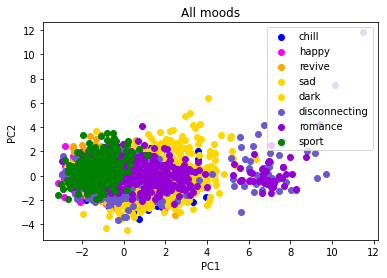

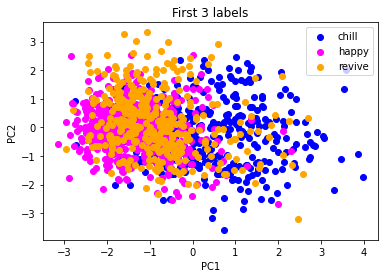

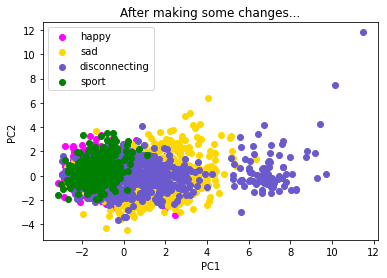

In [ ]:
## PCA 2- to plot

cLabel = {}
for l in range(len(labels.unique())):
  colors = ['blue', 'magenta', 'orange', 'gold', 'gold', 'slateblue', 'darkviolet','green', 'yellow',]
  cLabel[labels.unique()[l]] = colors[l]

print(cLabel)

fig, ax = plt.subplots()
for g in labels.unique():
    ix = np.where(ids_train.values == g)
    ax.scatter(train[ix,0], train[ix,1], c=cLabel[g], label=g) 
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('All moods')
plt.show() 

#disconnecting is also similar

fig, ax = plt.subplots()
for g in labels.unique()[:3]:
    ix = np.where(ids_train.values == g)
    ax.scatter(train[ix,0], train[ix,1], c=cLabel[g], label=g) 
plt.title('First 3 labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
#we can see that revive and happy is almost the same, lets put it together. Dark and sad seems also the same

fig, ax = plt.subplots()
for g in labels.unique()[1:8]:
  ix = np.where(ids_train.values == g)
  if g == 'revive':
    ax.scatter(train[ix,0], train[ix,1], c=cLabel['happy'])
  elif g=='dark':
    ax.scatter(train[ix,0], train[ix,1], c=cLabel['sad'])
  elif g=='romance':
    ax.scatter(train[ix,0], train[ix,1], c=cLabel['disconnecting'])
  else:
    ax.scatter(train[ix,0], train[ix,1], c=cLabel[g], label=g) 
plt.title('After making some changes...')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [ ]:
#@title making changes....
np.random.seed(n) 
def changes_labels(x):
  if x == 'revive': return 'happy'
  if x=='dark': return 'sad' #until here acc=0.57¡6
  #if x=='disconnecting': return 'sport' (with this acc=0.52)
  if x=='romance': return 'disconnecting' #with it acc=0.58
  return x


labels_new = labels[labels != 'chill']
df_scaled_new = df_scaled[labels != 'chill']

labels_new = dict([(x , changes_labels(labels_new[x])) for x in labels_new.keys()])
dflabels = pd.DataFrame.from_dict(labels_new, orient='index')
labels_new = dflabels[0].values

## KNN
# Split dataset into training set and test set
train, test, ids_train, ids_test = train_test_split(df_scaled_new, labels_new, test_size=0.2) # 70% training and 30% test

#___________________________________________________
metrics_knn = ['cosine', 'euclidean', 'manhattan']
best_acc = 0
solutions = pd.DataFrame(columns=['K', 'Metric', 'Acc'])
for k in range(len(np.unique(labels_new)), len(np.unique(labels_new))+10):
  for m in metrics_knn:
    knn = KNeighborsClassifier(n_neighbors=k, metric = m)

    #Train the model using the training sets
    knn.fit(train, ids_train)

    #Predict the response for test dataset
    y_pred = knn.predict(test)
    acc = metrics.accuracy_score(ids_test, y_pred)
    print("K -", k," Metric -",m, " ----- Accuracy:",acc)
    solutions = solutions.append({'K':k, 'Metric':m, 'Acc': acc}, ignore_index = True)

    if acc> best_acc:
      best_acc = acc
      best_param = [k, m]


print(f"\nThe best acc ({best_acc}) has combination: K-{best_param[0]} and metric-{best_param[1]}")

K - 4  Metric - cosine  ----- Accuracy: 0.594017094017094
K - 4  Metric - euclidean  ----- Accuracy: 0.5925925925925926
K - 4  Metric - manhattan  ----- Accuracy: 0.5854700854700855
K - 5  Metric - cosine  ----- Accuracy: 0.594017094017094
K - 5  Metric - euclidean  ----- Accuracy: 0.6082621082621082
K - 5  Metric - manhattan  ----- Accuracy: 0.6054131054131054
K - 6  Metric - cosine  ----- Accuracy: 0.5925925925925926
K - 6  Metric - euclidean  ----- Accuracy: 0.6125356125356125
K - 6  Metric - manhattan  ----- Accuracy: 0.6082621082621082
K - 7  Metric - cosine  ----- Accuracy: 0.6210826210826211
K - 7  Metric - euclidean  ----- Accuracy: 0.6153846153846154
K - 7  Metric - manhattan  ----- Accuracy: 0.6253561253561254
K - 8  Metric - cosine  ----- Accuracy: 0.6011396011396012
K - 8  Metric - euclidean  ----- Accuracy: 0.6253561253561254
K - 8  Metric - manhattan  ----- Accuracy: 0.6239316239316239
K - 9  Metric - cosine  ----- Accuracy: 0.6267806267806267
K - 9  Metric - euclidean  -

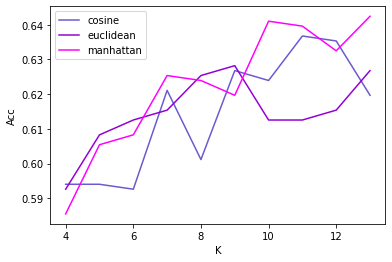

In [ ]:
## some plots 
cLabel = {}
for l in range(len(metrics_knn)):
  colors = ['slateblue', 'darkviolet', 'magenta']
  cLabel[metrics_knn[l]] = colors[l]

fig, ax = plt.subplots()
for g in metrics_knn:
    sol = solutions[solutions['Metric'] == g]
    ax.plot(sol['K'], sol['Acc'], c=cLabel[g], label=g) 
plt.xlabel('K')
plt.ylabel('Acc')
plt.legend()
plt.show() 

In [ ]:
#@title Test with test_song
knn = KNeighborsClassifier(n_neighbors=k, metric = m)
knn.fit(df_scaled_new, labels_new)

#it has to go through all the transformations
test_song1 = test_song.values
test_song1 = scaler.transform([test_song1])
test_song_p = knn.predict(test_song1)
label_song = changes_labels(label_song)

print(f'Song predicted in cluster {test_song_p} and it was label {label_song}')

Song predicted in cluster ['happy'] and it was label happy


In [ ]:
preds = knn.predict(df_scaled_new)

num_p = random.sample(range(len(preds)), 10)
for p in num_p:
  print(f'Song (id = {dflabels.iloc[p,:].name}) predicted in cluster {preds[p]} and it was label {labels_new[p]}')

Song (id = 72fp5rYlQIZ3Dqtwq2uVy0) predicted in cluster sad and it was label sad
Song (id = 4MA4LxSsJRbj4axg1uTi2n) predicted in cluster happy and it was label sport
Song (id = 0PtLrH95CQ2lKf6pym5LmA) predicted in cluster happy and it was label happy
Song (id = 1algWk375QvT1XNJJbRsGM) predicted in cluster sad and it was label sad
Song (id = 7e5HVLu9xSydLebKSqBebM) predicted in cluster sad and it was label sad
Song (id = 3bKFDxDxHokwoSMgv3SjXt) predicted in cluster sport and it was label sport
Song (id = 3lyLqIn8mybyEFTs8JJaLf) predicted in cluster disconnecting and it was label disconnecting
Song (id = 6FuGJB290AQMAHTfjOYVaK) predicted in cluster happy and it was label happy
Song (id = 5yGVHzJ2Se8pDzR7FIYUlU) predicted in cluster sad and it was label happy
Song (id = 7N06jo3EnV792VFaG8vuW6) predicted in cluster happy and it was label sport


# Using the KNN for the country csv

In [ ]:
#we use the same approach as in the Top-Analysis notebook to read the csv

data = pd.read_csv('song_feat_top.csv').drop('Unnamed: 0',axis =1)
data.drop('release_date', axis = 1, inplace = True)

num = data.select_dtypes(['float64', 'int64']).columns.tolist()
num_data = data[num]

scaler = StandardScaler()
num_data = scaler.fit_transform(num_data)
num_data = pd.DataFrame(num_data, columns = num)

data = pd.concat([num_data, data['id'], data['country']], axis = 1)
data.set_index('id', inplace = True)


## Using country mean

In [ ]:
#group by country using the mean
country_df = data.groupby(['country']).mean()
country_df

In [ ]:
#@title KNN...
country_mood = {}

for c in country_df.index:
  c1 = country_df.loc[c,:].values #already normalized
  cp = knn.predict([c1])
  
  country_mood[c] = cp

In [ ]:
countryMood_df= pd.DataFrame.from_dict(country_mood, orient='index', columns=['mood'])
countryMood_df

,mood
Alemania,disconnecting
Arabia Saudí,happy
Argentina,happy
Australia,happy
Austria,disconnecting
...,...
Taiwán,sad
Turquía,disconnecting
Ucrania,happy
Uruguay,happy


In [ ]:
#countryMood_df.to_csv('/content/drive/MyDrive/Colab Notebooks/WebAnalytics/final/contryMood.csv', index = False)

## Getting percentage for mood

In [ ]:
countries = data['country']
data2 = data.drop('country', axis = 1)

#knn
data['mood']= knn.predict(data2.values)

In [ ]:
labs = np.unique(labels_new) #the new columns
temp = dict([(i,[]) for i in labs])
temp['country'] = []

new_data = data[['country', 'mood']]

for c in countries.unique():
  moods = new_data[new_data.country == c].mood
  m = Counter(moods) #normally 50, not always
  temp['country'].append(c)
  for i in labs:
    try:
      temp[i].append(m[i]/len(moods))
    except:
      temp[i].append(0)

In [ ]:
count_country = pd.DataFrame(temp)
count_country.set_index('country', inplace=True)

In [ ]:
count_country['moodTop'] = [max(dict(count_country.loc[i,:]), key=dict(count_country.loc[i,:]).get) for i in count_country.index]
count_country['moodMean'] = countryMood_df
count_country.reset_index(inplace=True)
count_country = count_country.rename(columns = {'index':'country'})
count_country

,country,disconnecting,happy,sad,sport,moodTop,moodMean
0,Global,0.120000,0.520000,0.340,0.020,happy,sad
1,Taiwán,0.220000,0.340000,0.420,0.020,sad,sad
2,Turquía,0.200000,0.220000,0.500,0.080,sad,disconnecting
3,Reino Unido,0.220000,0.520000,0.200,0.060,happy,happy
4,Dinamarca,0.300000,0.340000,0.340,0.020,happy,sad
...,...,...,...,...,...,...,...
64,Suriname,0.104167,0.645833,0.125,0.125,happy,happy
65,La República Checa,0.140000,0.420000,0.380,0.060,happy,sad
66,Guatemala,0.160000,0.620000,0.200,0.020,happy,happy
67,Eslovaquia,0.180000,0.360000,0.420,0.040,sad,disconnecting


In [ ]:
#count_country.to_csv('/content/drive/MyDrive/Colab Notebooks/WebAnalytics/final/contryMood.csv', index = False)